# **Stereo Vision**

## **Startup Code**

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

**Convenience Functions**

In [9]:
# Function to convert 2D coordinates to homogeneous coordinates
def to_homogeneous(coordinates):
    if not isinstance(coordinates, np.ndarray):
        raise ValueError("Input must be a NumPy array")
    if coordinates.shape[1] != 2:
        raise ValueError("Input array must have shape (N, 2)")
    
    # Add a column of ones to the coordinates to make them homogeneous
    homogeneous_coordinates = np.hstack((coordinates, np.ones((coordinates.shape[0], 1))))
    
    return homogeneous_coordinates

# Function to convert homogeneous coordinates to non-homogeneous coordinates
def from_homogeneous(coordinates):
    if not isinstance(coordinates, np.ndarray):
        raise ValueError("Input must be a NumPy array")
    if coordinates.shape[1] != 3:
        raise ValueError("Input array must have shape (N, 3)")
    
    # Divide the first two columns by the third column to obtain non-homogeneous coordinates
    non_homogeneous_coordinates = coordinates[:, :2] / coordinates[:, 2][:, None]
    
    return non_homogeneous_coordinates

## **1. Epipolar Geometry**

### **1.1 Theory**

I think it'll be more effective to learn about this topic through a video rather than reading about it. You might want to watch this video on [Epipolar Geometry](https://www.youtube.com/watch?v=VoJy8Xbo9Uo).

### **1.2 Implementation**

In terms of implementation, the professor provided us with two examples. 

The first example involved two images, one of which featured a single dot. Our task was to identify the corresponding line in the second image that contained the dot from the first image.

The second example is image rectification, which is the process of finding two homographies that make stereo images parallel. This means that the epipolar lines in the two images become parallel horizontal lines, all having the same y-coordinate.

#### **1.2.1 Example 1**

**Essential Matrix & Fundamental Matrix**

The two fundamental matrices in the field of multi-view geometry are the fundamental and essential matrix:

- **Essential Matrix**: Encapsulates the geometric relationship between corresponding points in two calibrated images of a scene taken from different viewpoints. It enables the derivation of both the translation and rotation matrices necessary to transition between viewpoints.

- **Fundamental Matrix**: Describes the geometric relationship between corresponding points in two calibrated images of a scene taken from different viewpoints. It includes constraints on the position of corresponding points and defines the epipolar lines, which are crucial for establishing correspondence between points in different images.

For example, say we take two pictures of the same thing, but from slightly different angles.

- The **essential matrix** helps us figure out exactly how much the object has moved and rotated between those two photos. It's like having a map that shows us how to go from one photo to the other, considering both the distance traveled and the rotation.

- The **fundamental matrix** helps us find corresponding points between these photos. It's like having a special rulebook that tells us how to match up points in one photo with points in the other. This rulebook considers not only the position of the points but also the geometry of how the two photos are related to each other. It helps us draw lines (epipolar lines) in one photo, which tell us where we're likely to find the corresponding points in the other photo.

Below is the code to obtain both of these matrices:

In [50]:
# Read images
img1 = cv2.imread('./data/images/left1.jpg', cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread('./data/images/right1.jpg', cv2.IMREAD_GRAYSCALE) 

# Create SIFT object
sift = cv2.SIFT_create() 

# Detect keypoints and compute descriptors using SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Perform KNN matching
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test as per Lowe's paper
pts1 = []
pts2 = [] 
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

# Convert matched points to numpy arrays
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)

# Finding essential matrix using RANSAC
E, mask = cv2.findEssentialMat(pts1_, pts2_, np.eye(3), cv2.RANSAC)

# Decompose the essential matrix to rotation matrices and translation
R1, R2, t = cv2.decomposeEssentialMat(E)

# Select only inlier points
pts1_ = pts1_[mask.ravel() == 1]
pts2_ = pts2_[mask.ravel() == 1]

# Finding Fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1_, pts2_, cv2.RANSAC)

# Select only inlier points based on the mask
pts1_ = pts1_[mask.ravel() == 1]
pts2_ = pts2_[mask.ravel() == 1]

Now that we have the essential and fundamental matrices, we can plot the epipolar lines and their corresponding points. The code provided below selects a random point on the second image (for each run) and draws the corresponding line in the first image.

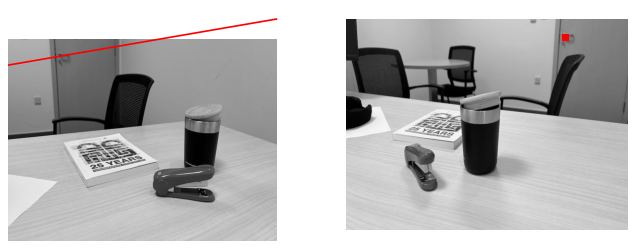

In [53]:
# Compute epipolar lines in the first image using the Fundamental matrix
lines1 = to_homogeneous(pts2_).dot(F)

# Get image dimensions
r, c = img1.shape

# Index of the point for which to plot the epipolar line
pts_index = np.random.randint(low = 0, high = len(lines1))

# Extract coefficients of the epipolar line
a = lines1[pts_index, 0]
b = lines1[pts_index, 1]
c = lines1[pts_index, 2]

# Plotting
plt.figure(figsize=(10,6))

# Plot first image with the epipolar line
plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.axis('off')
# Compute the endpoints of the epipolar line
y0 = -c/b
y1 = (-c - a * img1.shape[1]) / b
# Plot the epipolar line on the first image
plt.plot([0, img1.shape[1]], [y0, y1], 'r')

# Plot second image with the corresponding point
plt.subplot(122)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.plot(pts2_[pts_index, 0], pts2_[pts_index, 1], 'rs', markersize = 5)

plt.show()

#### **1.2.2 Example 2: Image Rectification**

For this example, we are provided with the following two images.

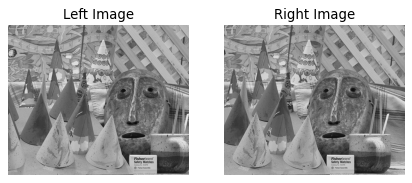

In [62]:
# Read images
img1 = cv2.imread('./data/images/left2.png', cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread('./data/images/right2.png', cv2.IMREAD_GRAYSCALE)

# Plot images
plt.subplot(121)
plt.imshow(img1, cmap = 'gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(img2, cmap = 'gray')
plt.title('Right Image')
plt.axis('off')

plt.show()

Now these two images may seem the same but if you were to zoom in you would realize they are actually displaced from one another. 

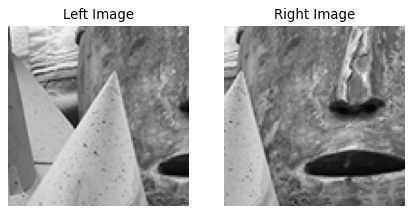

In [61]:
# Plot images
plt.subplot(121)
plt.imshow(img1[200:300, 200:300], cmap = 'gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(img2[200:300, 200:300], cmap = 'gray')
plt.title('Right Image')
plt.axis('off')

plt.show()

Our objective is to find two homography matrices that will render the two images parallel. By "parallel," we mean that the epipolar lines in the two images become parallel horizontal lines sharing the same y-coordinate.

Below is the code to achieve this task.

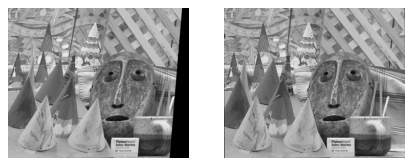

In [67]:
sift = cv2.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)

# Finding Fundamental matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
F, mask = cv2.findFundamentalMat(pts1_, pts2_, cv2.RANSAC)

# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

h,w = img1.shape
# find the two homographies
_, H1, H2 = cv2.stereoRectifyUncalibrated(pts1_, pts2_, F, (w,h))
# Appling the two homographies to the two images to rectify them
rectified_img1 = cv2.warpPerspective(img1, H1, (w,h), flags=cv2.INTER_LINEAR)
rectified_img2 = cv2.warpPerspective(img2, H2, (w,h), flags=cv2.INTER_LINEAR)


# Plots
plt.subplot(121), plt.imshow(rectified_img1, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.imshow(rectified_img2, cmap='gray'), plt.axis('off')
plt.show()

To see the change better:

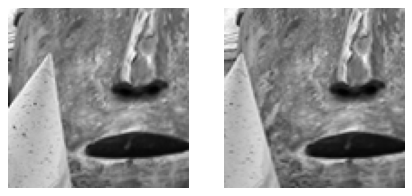

In [68]:
# Plots
plt.subplot(121), plt.imshow(rectified_img1[200:300, 200:300], cmap='gray'), plt.axis('off')
plt.subplot(122), plt.imshow(rectified_img2[200:300, 200:300], cmap='gray'), plt.axis('off')
plt.show()

## **2. Depth Map**

### **2.1 Theory**

I think it'll be more effective to learn about this topic through a video rather than reading about it. You might want to watch this video on [Depth Map](https://www.youtube.com/watch?v=gffZ3S9pBUE).

### **2.2 Implementation**

The relevant functions for this segment are:

`cv2.StereoBM_create(numDisparities, blockSize)` used to create an instance of the StereoBM algorithm, which stands for Stereo Block Matching.
- **numDisparities**: Specifies the number of disparities to be considered during stereo matching.
- **blockSize**: Defines the size of the window used for matching

For instance, if the `numDisparities` parameter is set to 8, the algorithm will segment each pixel into one of 8 depth ranges, varying from disparity 0 to disparity 7. A lower disparity value indicates that the pixel is closer to the camera, whereas a higher disparity value suggests that the pixel is further from the image. Therefore, with `numDisparities` set to 8, the algorithm considers 8 disparity levels, enabling it to estimate depth across a certain range of distances in the scene.

Regarding the `blockSize` parameter, to estimate depth accurately, we must locate corresponding points in the stereo images. These points represent the same 3D location in the scene but appear in different positions in each image due to the camera separation. The `blockSize` parameter dictates the size of the neighborhood or window around each pixel that we analyze when searching for corresponding points. For example, if the `blockSize` were set to 5, then for every pixel in the first image, the algorithm would compare its 5x5 pixel neighborhood with the corresponding neighborhoods in the other image to identify the best matching points.

`stereo.compute(rectified_img1, rectified_img2)` is used to compute the disparity map from a pair of rectified stero images.
- **rectified_img1**: The left rectified image of the stereo pair.
- **rectified_img2**: The right rectified image of the stereo pair.

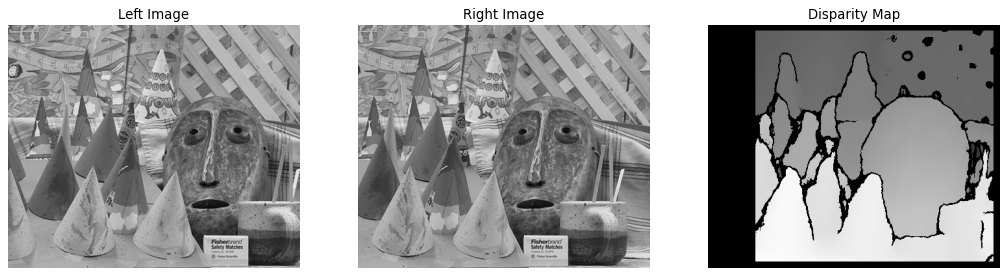

In [84]:
# Read images
img1 = cv2.imread('./data/images/left2.png', cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread('./data/images/right2.png', cv2.IMREAD_GRAYSCALE)

# Create a StereoBM object with specified parameters
stereo = cv2.StereoBM_create(numDisparities=0, blockSize=21) # Play w/ these value

# Compute the disparity map using StereoBM
disparity = stereo.compute(img1, img2)

# Display the images and disparity map
plt.figure(figsize=(16, 9))

# Subplot 1: Left Image
plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title("Left Image")
plt.axis('off')

# Subplot 2: Right Image
plt.subplot(132)
plt.imshow(img2, cmap='gray')
plt.title("Right Image")
plt.axis('off')

# Subplot 3: Disparity Map
plt.subplot(133)
plt.imshow(disparity, 'gray')
plt.title('Disparity Map')
plt.axis('off')

plt.show()